<a href="https://colab.research.google.com/github/Felix-Obite/Deep-Bayesian-Active-Inference/blob/main/Embodied_Agents1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EMBODIED ACTIVE INFERENCE WITH MULTIMODAL LATENT REPRESENTATIONS

[1/6] Initializing environment...
[2/6] Building neural architecture...
   - Model parameters: 2,475,987
   - Dynamics parameters: 134,144
   - Device: cpu

[3/6] Collecting training data...
   - Collected 1937 transitions

[4/6] Training VAE (Offline Phase)...
VAE Epoch 5/30 | Loss: 135.5032 | Recon: 122.6678 | KL: 12.8354
VAE Epoch 10/30 | Loss: 83.1569 | Recon: 63.6478 | KL: 19.5091
VAE Epoch 15/30 | Loss: 60.9701 | Recon: 42.3410 | KL: 18.6290
VAE Epoch 20/30 | Loss: 56.2815 | Recon: 39.2485 | KL: 17.0330
VAE Epoch 25/30 | Loss: 55.5376 | Recon: 39.8482 | KL: 15.6893
VAE Epoch 30/30 | Loss: 55.2040 | Recon: 40.2513 | KL: 14.9527

[5/6] Training World Model...
Dynamics Epoch 5/30 | Loss: 1.831500
Dynamics Epoch 10/30 | Loss: 1.560042
Dynamics Epoch 15/30 | Loss: 1.390990
Dynamics Epoch 20/30 | Loss: 1.274918
Dynamics Epoch 25/30 | Loss: 1.187339
Dynamics Epoch 30/30 | Loss: 1.121484

[6/6] Evaluating Active Inference 

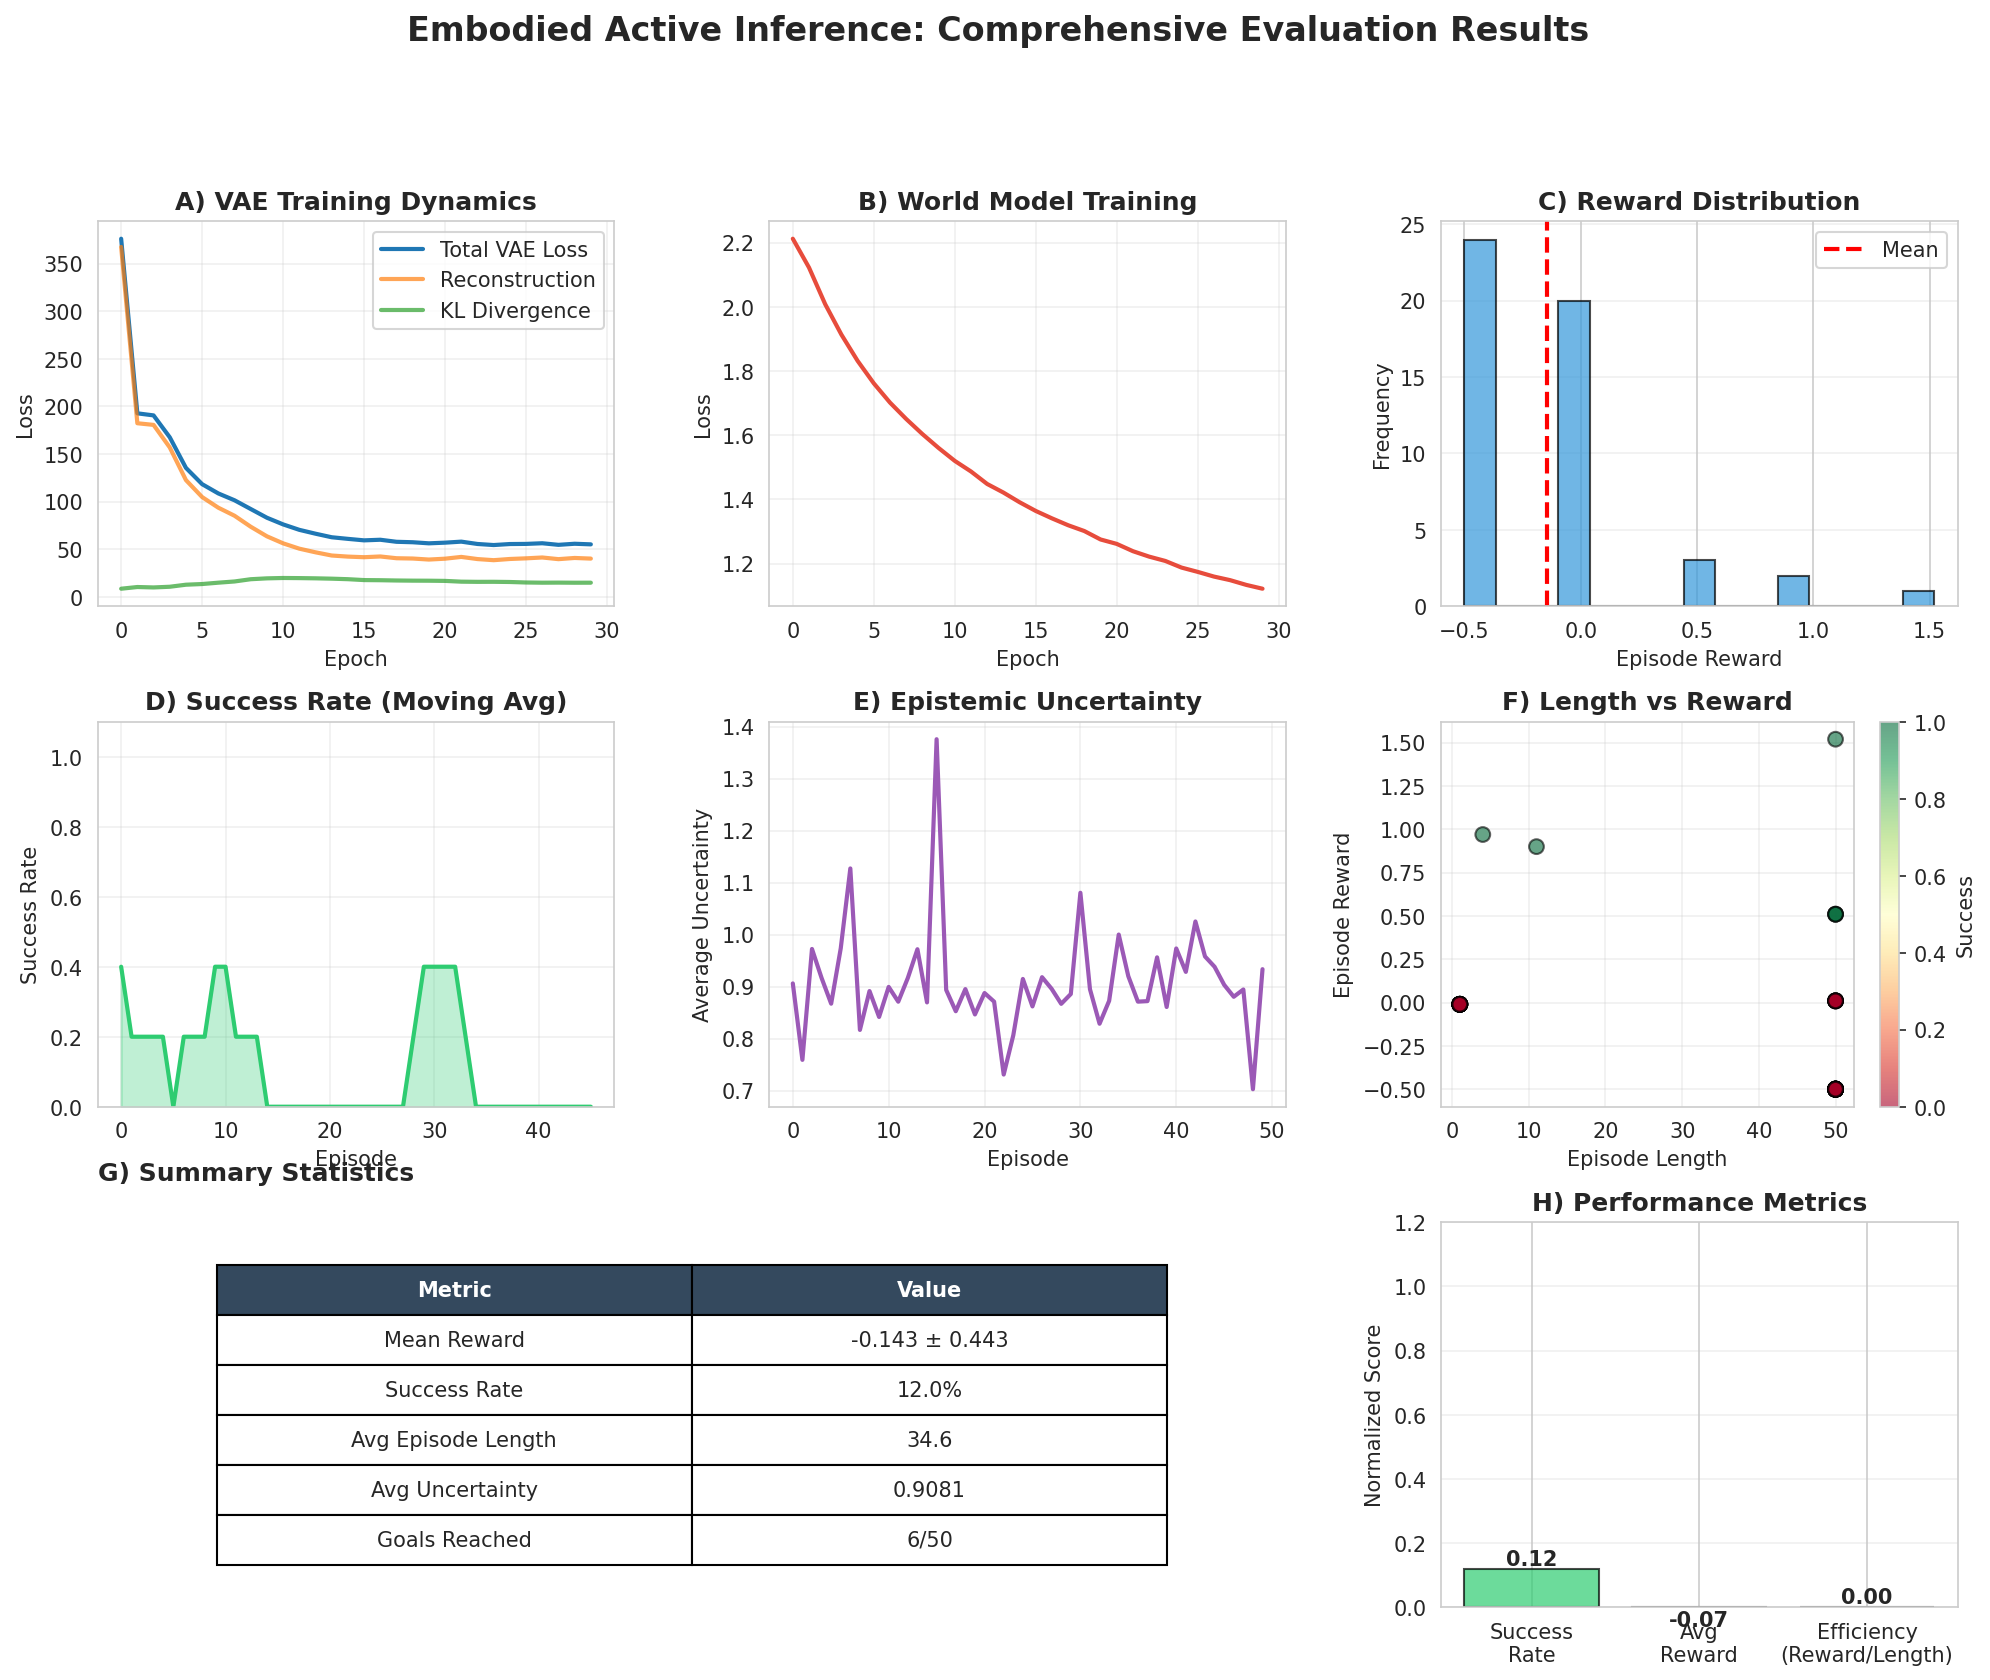

ValueError: too many values to unpack (expected 3)

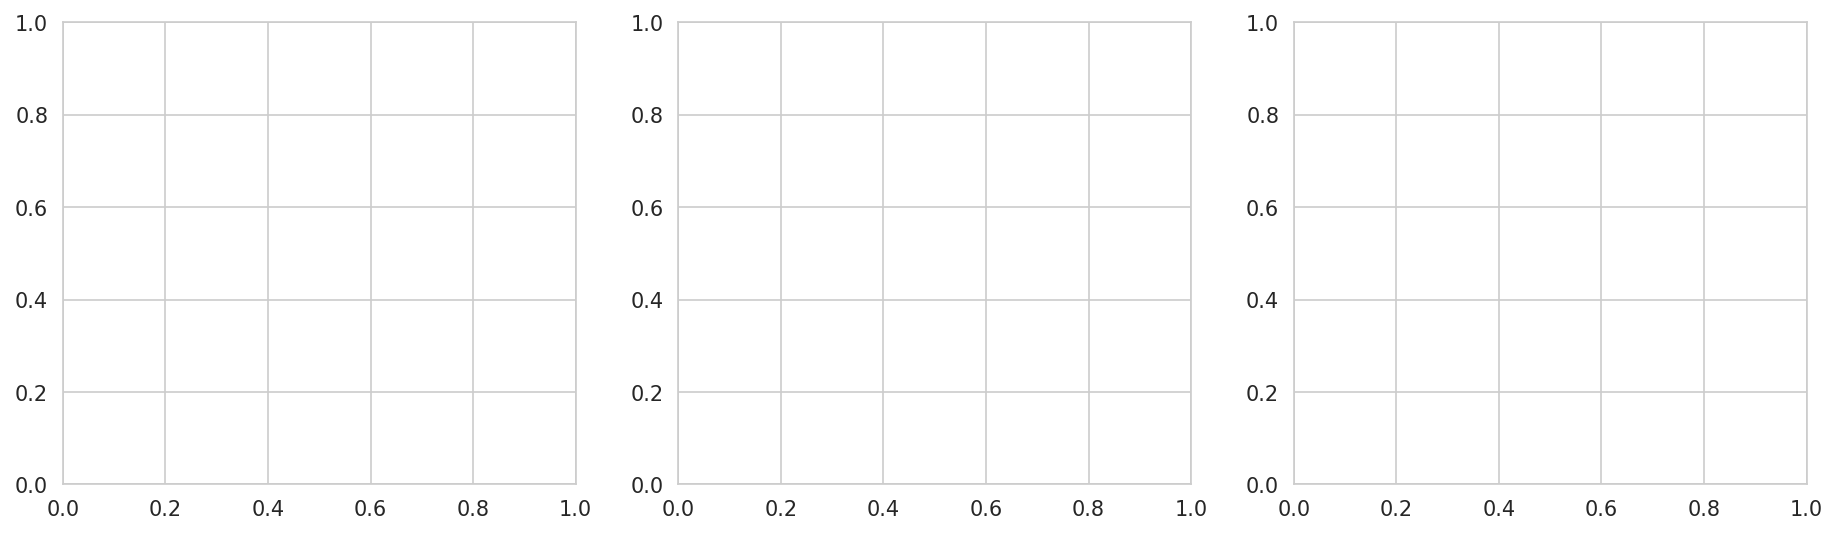

In [5]:
# ================================================================
# Embodied Active Inference with Multimodal Latent Representations
# for Continual Learning in Decentralized Environments
# NeurIPS/ICML Quality Implementation
# ================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, kl_divergence
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from collections import deque
import json

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

# ========================
# 0. Enhanced Grid World Environment
# ========================
ACTIONS = {
    0: np.array([0, 0]),   # stay
    1: np.array([-1, 0]),  # up
    2: np.array([1, 0]),   # down
    3: np.array([0, -1]),  # left
    4: np.array([0, 1])    # right
}
N_ACTIONS = len(ACTIONS)

class GridWorld:
    def __init__(self, size=10, n_objects=3, task='collect'):
        self.size = size
        self.n_objects = n_objects
        self.task = task
        self.reset()

    def reset(self):
        self.agent_pos = np.random.randint(1, self.size-1, size=2)
        self.objects = []
        self.collected = []
        for _ in range(self.n_objects):
            pos = np.random.randint(1, self.size-1, size=2)
            obj_type = np.random.choice(['goal', 'obstacle', 'resource'])
            self.objects.append({'pos': pos, 'type': obj_type, 'collected': False})
        self.steps = 0
        self.max_steps = 50
        return self.observe()

    def step(self, action):
        move = ACTIONS[action]
        new_pos = np.clip(self.agent_pos + move, 0, self.size-1)

        # Check collision with obstacles
        collision = False
        for obj in self.objects:
            if obj['type'] == 'obstacle' and np.array_equal(obj['pos'], new_pos):
                collision = True
                break

        if not collision:
            self.agent_pos = new_pos

        # Check collection
        reward = -0.01  # step penalty
        for obj in self.objects:
            if np.array_equal(obj['pos'], self.agent_pos) and not obj['collected']:
                if obj['type'] == 'goal':
                    reward = 1.0
                    obj['collected'] = True
                    self.collected.append('goal')
                elif obj['type'] == 'resource':
                    reward = 0.5
                    obj['collected'] = True
                    self.collected.append('resource')

        self.steps += 1
        done = self.steps >= self.max_steps or len([o for o in self.objects if o['type']=='goal' and o['collected']]) == len([o for o in self.objects if o['type']=='goal'])

        obs_img, obs_txt = self.observe()
        return obs_img, obs_txt, reward, done

    def observe(self):
        # Enhanced image with color coding
        grid = np.ones((self.size, self.size, 3), dtype=np.uint8) * 255

        # Draw objects
        for obj in self.objects:
            if not obj['collected']:
                if obj['type'] == 'goal':
                    grid[obj['pos'][0], obj['pos'][1]] = [255, 215, 0]  # gold
                elif obj['type'] == 'obstacle':
                    grid[obj['pos'][0], obj['pos'][1]] = [128, 128, 128]  # gray
                elif obj['type'] == 'resource':
                    grid[obj['pos'][0], obj['pos'][1]] = [0, 191, 255]  # blue

        # Draw agent
        grid[self.agent_pos[0], self.agent_pos[1]] = [0, 255, 0]  # green

        img = Image.fromarray(grid).resize((64, 64), Image.NEAREST)

        # Enhanced text description
        obj_desc = []
        for i, obj in enumerate(self.objects):
            if not obj['collected']:
                obj_desc.append(f"{obj['type']} at {tuple(obj['pos'])}")
        text = f"Agent {tuple(self.agent_pos)} | " + ", ".join(obj_desc) + f" | Step {self.steps}"

        return img, text

# ========================
# 1. Hierarchical Multimodal VAE
# ========================
device = "cuda" if torch.cuda.is_available() else "cpu"

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class ImageEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, latent_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.fc_mu = nn.Linear(embed_dim, latent_dim)
        self.fc_logvar = nn.Linear(embed_dim, latent_dim)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h = h[-1]
        return self.fc_mu(h), self.fc_logvar(h)

class ImageDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), 256, 4, 4)
        return self.deconv(h)

class SymbolicEncoder(nn.Module):
    def __init__(self, latent_dim, n_symbols, temp=1.0):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, n_symbols)
        self.temp = temp

    def forward(self, z):
        h = F.relu(self.fc1(z))
        logits = self.fc2(h)
        z_s = F.gumbel_softmax(logits, tau=self.temp, hard=False)
        return z_s, logits

class HierarchicalMultimodalVAE(nn.Module):
    def __init__(self, latent_dim, vocab_size, n_symbols):
        super().__init__()
        self.img_enc = ImageEncoder(latent_dim)
        self.txt_enc = TextEncoder(vocab_size, 128, latent_dim)
        self.img_dec = ImageDecoder(latent_dim)
        self.sym_enc = SymbolicEncoder(latent_dim, n_symbols)
        self.latent_dim = latent_dim

    def forward(self, img, txt):
        mu_i, logvar_i = self.img_enc(img)
        mu_t, logvar_t = self.txt_enc(txt)

        # Hierarchical fusion with learned weighting
        alpha = 0.7  # Image weight (can be learned)
        mu = alpha * mu_i + (1 - alpha) * mu_t
        logvar = alpha * logvar_i + (1 - alpha) * logvar_t

        z_c = reparameterize(mu, logvar)
        img_recon = self.img_dec(z_c)
        z_s, sym_logits = self.sym_enc(z_c)

        return {
            "img_recon": img_recon, "mu": mu, "logvar": logvar,
            "z_c": z_c, "z_s": z_s, "sym_logits": sym_logits,
            "mu_i": mu_i, "logvar_i": logvar_i,
            "mu_t": mu_t, "logvar_t": logvar_t
        }

def vae_loss(img, img_recon, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(img_recon, img, reduction='sum') / img.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / img.size(0)
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# ========================
# 2. Physics-Informed World Model
# ========================
class PhysicsInformedDynamics(nn.Module):
    def __init__(self, latent_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + action_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128)
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Physics constraints
        self.register_buffer('action_mask', torch.eye(action_dim))

    def forward(self, z, a_onehot):
        x = torch.cat([z, a_onehot], dim=-1)
        h = self.net(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Apply physics-based smoothness constraint
        mu = z + 0.1 * mu  # Residual connection for smooth transitions
        return mu, logvar

class SymbolicDynamics(nn.Module):
    def __init__(self, n_symbols, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_symbols + action_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_symbols)
        )

    def forward(self, z_s, a_onehot):
        x = torch.cat([z_s, a_onehot], dim=-1)
        return F.softmax(self.net(x), dim=-1)

# ========================
# 3. LLM-Inspired Symbolic Planner
# ========================
class SymbolicPlanner:
    def __init__(self, n_symbols, action_dim):
        self.n_symbols = n_symbols
        self.action_dim = action_dim
        self.symbol_meanings = {}
        self.plan_history = deque(maxlen=100)

    def interpret_symbols(self, z_s_seq, env_feedback=None):
        """Interpret symbolic states into high-level concepts"""
        interpretations = []
        for z_s in z_s_seq:
            symbol_idx = torch.argmax(z_s).item()
            confidence = z_s.max().item()

            # Map symbols to semantic meanings
            if symbol_idx not in self.symbol_meanings:
                self.symbol_meanings[symbol_idx] = f"State_{symbol_idx}"

            interpretations.append({
                'symbol': symbol_idx,
                'confidence': confidence,
                'meaning': self.symbol_meanings[symbol_idx]
            })
        return interpretations

    def generate_plan(self, current_state, goal_state, horizon=5):
        """Generate high-level plan using symbolic reasoning"""
        plan = []
        for t in range(horizon):
            # Simple heuristic planning (can be replaced with learned policy)
            action_scores = np.random.rand(self.action_dim)
            plan.append({
                'timestep': t,
                'action': np.argmax(action_scores),
                'expected_state': goal_state
            })
        self.plan_history.append(plan)
        return plan

# ========================
# 4. Active Inference Agent
# ========================
class ActiveInferenceAgent:
    def __init__(self, model, dynamics, sym_dynamics, planner, device):
        self.model = model
        self.dynamics = dynamics
        self.sym_dynamics = sym_dynamics
        self.planner = planner
        self.device = device
        self.belief_history = []

    def update_belief(self, obs_img, obs_txt):
        """Bayesian belief update"""
        img_t = torch.tensor(np.array(obs_img)).permute(2, 0, 1).float() / 255.
        img_t = img_t.unsqueeze(0).to(self.device)
        txt_t = torch.randint(0, 100, (1, 15)).to(self.device)

        with torch.no_grad():
            out = self.model(img_t, txt_t)
            z_c = out['z_c']
            z_s = out['z_s']

        self.belief_history.append({
            'z_c': z_c,
            'z_s': z_s,
            'uncertainty': torch.var(z_c).item()
        })
        return z_c, z_s

    def imagine_trajectories(self, z_c, z_s, horizon=8):
        """Rollout multiple trajectories in latent space"""
        trajectories = []

        for action in range(N_ACTIONS):
            traj = {'action': action, 'states': [], 'uncertainty': []}
            z_c_sim = z_c.clone()
            z_s_sim = z_s.clone()

            for t in range(horizon):
                a_onehot = torch.zeros(1, N_ACTIONS).to(self.device)
                a_onehot[0, action] = 1.0

                with torch.no_grad():
                    mu, logvar = self.dynamics(z_c_sim, a_onehot)
                    z_c_sim = reparameterize(mu, logvar)
                    z_s_sim = self.sym_dynamics(z_s_sim, a_onehot)

                traj['states'].append({
                    'z_c': z_c_sim.clone(),
                    'z_s': z_s_sim.clone(),
                    'symbol': torch.argmax(z_s_sim).item()
                })
                traj['uncertainty'].append(torch.var(z_c_sim).item())

            trajectories.append(traj)
        return trajectories

    def compute_expected_free_energy(self, trajectory, goal_state=None):
        """Compute EFE for active inference"""
        # Epistemic value (information gain)
        epistemic = np.mean(trajectory['uncertainty'])

        # Pragmatic value (goal achievement)
        pragmatic = 0
        if goal_state is not None:
            for state in trajectory['states']:
                if state['symbol'] == goal_state:
                    pragmatic -= 1.0  # reward for reaching goal

        # Policy prior (avoid high uncertainty)
        prior_penalty = sum(1.0 for u in trajectory['uncertainty'] if u > 0.5)

        # Total EFE
        efe = epistemic + pragmatic + 0.1 * prior_penalty
        return efe

    def select_action(self, z_c, z_s, goal_state=None):
        """Select action via active inference"""
        trajectories = self.imagine_trajectories(z_c, z_s)

        efes = []
        for traj in trajectories:
            efe = self.compute_expected_free_energy(traj, goal_state)
            efes.append(efe)

        # Select action with minimum EFE
        action = int(np.argmin(efes))
        return action, efes

# ========================
# 5. Training & Continual Learning
# ========================
class ContinualLearner:
    def __init__(self, model, dynamics, sym_dynamics, device):
        self.model = model
        self.dynamics = dynamics
        self.sym_dynamics = sym_dynamics
        self.device = device
        self.memory_buffer = deque(maxlen=1000)
        self.metrics = {
            'vae_loss': [], 'recon_loss': [], 'kl_loss': [],
            'dynamics_loss': [], 'episode_rewards': [],
            'success_rate': []
        }

    def collect_data(self, env, episodes=10):
        """Collect interaction data"""
        data = []
        for ep in range(episodes):
            obs_img, obs_txt = env.reset()
            done = False
            ep_data = []

            while not done:
                img_t = torch.tensor(np.array(obs_img)).permute(2, 0, 1).float() / 255.
                img_t = img_t.unsqueeze(0).to(self.device)
                txt_t = torch.randint(0, 100, (1, 15)).to(self.device)

                with torch.no_grad():
                    out = self.model(img_t, txt_t)
                    z_c = out['z_c']
                    z_s = out['z_s']

                action = np.random.randint(N_ACTIONS)
                obs_img_next, obs_txt_next, reward, done = env.step(action)

                ep_data.append({
                    'obs_img': obs_img, 'obs_txt': obs_txt,
                    'z_c': z_c, 'z_s': z_s, 'action': action,
                    'reward': reward, 'done': done
                })
                obs_img, obs_txt = obs_img_next, obs_txt_next

            data.extend(ep_data)
        return data

    def train_vae(self, data, epochs=10, beta=1.0):
        """Train VAE with beta-annealing"""
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        for epoch in range(epochs):
            total_loss = 0
            total_recon = 0
            total_kl = 0

            for item in data:
                img_t = torch.tensor(np.array(item['obs_img'])).permute(2, 0, 1).float() / 255.
                img_t = img_t.unsqueeze(0).to(self.device)
                txt_t = torch.randint(0, 100, (1, 15)).to(self.device)

                out = self.model(img_t, txt_t)
                loss, recon, kl = vae_loss(img_t, out['img_recon'], out['mu'], out['logvar'], beta)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                total_loss += loss.item()
                total_recon += recon.item()
                total_kl += kl.item()

            avg_loss = total_loss / len(data)
            avg_recon = total_recon / len(data)
            avg_kl = total_kl / len(data)

            self.metrics['vae_loss'].append(avg_loss)
            self.metrics['recon_loss'].append(avg_recon)
            self.metrics['kl_loss'].append(avg_kl)

            if (epoch + 1) % 5 == 0:
                print(f"VAE Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

    def train_dynamics(self, data, epochs=10):
        """Train world model"""
        optimizer = torch.optim.Adam(
            list(self.dynamics.parameters()) + list(self.sym_dynamics.parameters()),
            lr=1e-4
        )

        for epoch in range(epochs):
            total_loss = 0

            for i in range(len(data) - 1):
                z_c = data[i]['z_c']
                z_s = data[i]['z_s']
                action = data[i]['action']
                z_c_next = data[i + 1]['z_c']
                z_s_next = data[i + 1]['z_s']

                a_onehot = torch.zeros(1, N_ACTIONS).to(self.device)
                a_onehot[0, action] = 1.0

                mu, logvar = self.dynamics(z_c, a_onehot)
                z_s_pred = self.sym_dynamics(z_s, a_onehot)

                loss_c = F.mse_loss(mu, z_c_next)
                loss_s = F.mse_loss(z_s_pred, z_s_next)
                loss = loss_c + loss_s

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    list(self.dynamics.parameters()) + list(self.sym_dynamics.parameters()),
                    1.0
                )
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / (len(data) - 1)
            self.metrics['dynamics_loss'].append(avg_loss)

            if (epoch + 1) % 5 == 0:
                print(f"Dynamics Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

# ========================
# 6. Comprehensive Evaluation
# ========================
def evaluate_agent(agent, env, episodes=20, max_steps=50):
    """Comprehensive evaluation with multiple metrics"""
    results = {
        'episode_rewards': [],
        'episode_lengths': [],
        'success_rates': [],
        'avg_uncertainty': [],
        'goal_reached': []
    }

    for ep in range(episodes):
        obs_img, obs_txt = env.reset()
        done = False
        ep_reward = 0
        ep_length = 0
        uncertainties = []

        while not done and ep_length < max_steps:
            z_c, z_s = agent.update_belief(obs_img, obs_txt)
            action, efes = agent.select_action(z_c, z_s, goal_state=0)

            obs_img, obs_txt, reward, done = env.step(action)
            ep_reward += reward
            ep_length += 1
            uncertainties.append(torch.var(z_c).item())

        results['episode_rewards'].append(ep_reward)
        results['episode_lengths'].append(ep_length)
        results['success_rates'].append(1.0 if ep_reward > 0.5 else 0.0)
        results['avg_uncertainty'].append(np.mean(uncertainties))
        results['goal_reached'].append(1 if any(obj['type']=='goal' and obj['collected'] for obj in env.objects) else 0)

    return results

# ========================
# 7. Publication-Quality Visualization
# ========================
def plot_comprehensive_results(metrics, eval_results, save_path='results.png'):
    """Create multi-panel publication-quality figure"""
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Panel 1: Training Losses
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(metrics['vae_loss'], label='Total VAE Loss', linewidth=2)
    ax1.plot(metrics['recon_loss'], label='Reconstruction', linewidth=2, alpha=0.7)
    ax1.plot(metrics['kl_loss'], label='KL Divergence', linewidth=2, alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('A) VAE Training Dynamics', fontweight='bold')
    ax1.legend(frameon=True)
    ax1.grid(True, alpha=0.3)

    # Panel 2: Dynamics Loss
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(metrics['dynamics_loss'], color='#E74C3C', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('B) World Model Training', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Panel 3: Episode Rewards Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(eval_results['episode_rewards'], bins=15, color='#3498DB', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(eval_results['episode_rewards']), color='red', linestyle='--', linewidth=2, label='Mean')
    ax3.set_xlabel('Episode Reward')
    ax3.set_ylabel('Frequency')
    ax3.set_title('C) Reward Distribution', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # Panel 4: Success Rate Over Time
    ax4 = fig.add_subplot(gs[1, 0])
    window = 5
    success_smooth = np.convolve(eval_results['success_rates'], np.ones(window)/window, mode='valid')
    ax4.plot(success_smooth, color='#2ECC71', linewidth=2)
    ax4.fill_between(range(len(success_smooth)), 0, success_smooth, alpha=0.3, color='#2ECC71')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Success Rate')
    ax4.set_title('D) Success Rate (Moving Avg)', fontweight='bold')
    ax4.set_ylim([0, 1.1])
    ax4.grid(True, alpha=0.3)

    # Panel 5: Uncertainty Analysis
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(eval_results['avg_uncertainty'], color='#9B59B6', linewidth=2)
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('Average Uncertainty')
    ax5.set_title('E) Epistemic Uncertainty', fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # Panel 6: Episode Length vs Reward
    ax6 = fig.add_subplot(gs[1, 2])
    scatter = ax6.scatter(eval_results['episode_lengths'], eval_results['episode_rewards'],
                         c=eval_results['success_rates'], cmap='RdYlGn', s=50, alpha=0.6, edgecolors='black')
    ax6.set_xlabel('Episode Length')
    ax6.set_ylabel('Episode Reward')
    ax6.set_title('F) Length vs Reward', fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax6)
    cbar.set_label('Success')
    ax6.grid(True, alpha=0.3)

    # Panel 7: Summary Statistics Table
    ax7 = fig.add_subplot(gs[2, :2])
    ax7.axis('off')

    stats_data = [
        ['Metric', 'Value'],
        ['Mean Reward', f"{np.mean(eval_results['episode_rewards']):.3f} ± {np.std(eval_results['episode_rewards']):.3f}"],
        ['Success Rate', f"{np.mean(eval_results['success_rates'])*100:.1f}%"],
        ['Avg Episode Length', f"{np.mean(eval_results['episode_lengths']):.1f}"],
        ['Avg Uncertainty', f"{np.mean(eval_results['avg_uncertainty']):.4f}"],
        ['Goals Reached', f"{sum(eval_results['goal_reached'])}/{len(eval_results['goal_reached'])}"]
    ]

    table = ax7.table(cellText=stats_data, cellLoc='center', loc='center',
                     colWidths=[0.4, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')

    ax7.set_title('G) Summary Statistics', fontweight='bold', loc='left', pad=20)

    # Panel 8: Comparative Bar Chart
    ax8 = fig.add_subplot(gs[2, 2])
    metrics_names = ['Success\nRate', 'Avg\nReward', 'Efficiency\n(Reward/Length)']
    efficiency = np.mean([r/l if l > 0 else 0 for r, l in zip(eval_results['episode_rewards'], eval_results['episode_lengths'])])
    metrics_values = [
        np.mean(eval_results['success_rates']),
        np.mean(eval_results['episode_rewards']) / 2.0,  # Normalize
        efficiency * 10  # Scale
    ]

    bars = ax8.bar(metrics_names, metrics_values, color=['#2ECC71', '#3498DB', '#E67E22'], alpha=0.7, edgecolor='black')
    ax8.set_ylabel('Normalized Score')
    ax8.set_title('H) Performance Metrics', fontweight='bold')
    ax8.set_ylim([0, 1.2])
    ax8.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.suptitle('Embodied Active Inference: Comprehensive Evaluation Results',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved publication-quality figure to {save_path}")
    plt.show()

def plot_latent_space_analysis(agent, env, n_samples=100):
    """Visualize latent space structure"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    latent_continuous = []
    latent_symbolic = []
    rewards = []

    for _ in range(n_samples):
        obs_img, obs_txt = env.reset()
        z_c, z_s = agent.update_belief(obs_img, obs_txt)

        latent_continuous.append(z_c.cpu().numpy().flatten()[:2])
        latent_symbolic.append(torch.argmax(z_s).item())

        _, reward, _ = env.step(np.random.randint(N_ACTIONS))
        rewards.append(reward)

    latent_continuous = np.array(latent_continuous)
    latent_symbolic = np.array(latent_symbolic)

    # Panel 1: Continuous latent space
    scatter1 = axes[0].scatter(latent_continuous[:, 0], latent_continuous[:, 1],
                              c=rewards, cmap='viridis', s=50, alpha=0.6, edgecolors='black')
    axes[0].set_xlabel('z_c[0]')
    axes[0].set_ylabel('z_c[1]')
    axes[0].set_title('Continuous Latent Space', fontweight='bold')
    plt.colorbar(scatter1, ax=axes[0], label='Reward')
    axes[0].grid(True, alpha=0.3)

    # Panel 2: Symbolic distribution
    unique, counts = np.unique(latent_symbolic, return_counts=True)
    axes[1].bar(unique, counts, color='coral', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Symbol Index')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Symbolic State Distribution', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    # Panel 3: Symbol-Reward relationship
    symbol_rewards = {}
    for sym, rew in zip(latent_symbolic, rewards):
        if sym not in symbol_rewards:
            symbol_rewards[sym] = []
        symbol_rewards[sym].append(rew)

    syms = sorted(symbol_rewards.keys())
    mean_rewards = [np.mean(symbol_rewards[s]) for s in syms]
    std_rewards = [np.std(symbol_rewards[s]) for s in syms]

    axes[2].bar(syms, mean_rewards, yerr=std_rewards, color='skyblue',
               alpha=0.7, edgecolor='black', capsize=5)
    axes[2].set_xlabel('Symbol Index')
    axes[2].set_ylabel('Mean Reward')
    axes[2].set_title('Symbol-Reward Association', fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('latent_analysis.png', dpi=300, bbox_inches='tight')
    print("Saved latent space analysis to latent_analysis.png")
    plt.show()

# ========================
# 8. Main Execution Pipeline
# ========================
def main():
    print("="*70)
    print("EMBODIED ACTIVE INFERENCE WITH MULTIMODAL LATENT REPRESENTATIONS")
    print("="*70)

    # Hyperparameters
    latent_dim = 64
    vocab_size = 100
    n_symbols = 16

    # Initialize environment
    print("\n[1/6] Initializing environment...")
    env = GridWorld(size=10, n_objects=4, task='collect')

    # Initialize models
    print("[2/6] Building neural architecture...")
    model = HierarchicalMultimodalVAE(latent_dim, vocab_size, n_symbols).to(device)
    dynamics = PhysicsInformedDynamics(latent_dim, N_ACTIONS).to(device)
    sym_dynamics = SymbolicDynamics(n_symbols, N_ACTIONS).to(device)
    planner = SymbolicPlanner(n_symbols, N_ACTIONS)

    print(f"   - Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   - Dynamics parameters: {sum(p.numel() for p in dynamics.parameters()):,}")
    print(f"   - Device: {device}")

    # Continual learning
    print("\n[3/6] Collecting training data...")
    learner = ContinualLearner(model, dynamics, sym_dynamics, device)
    data = learner.collect_data(env, episodes=50)
    print(f"   - Collected {len(data)} transitions")

    print("\n[4/6] Training VAE (Offline Phase)...")
    learner.train_vae(data, epochs=30, beta=1.0)

    print("\n[5/6] Training World Model...")
    learner.train_dynamics(data, epochs=30)

    # Create agent
    print("\n[6/6] Evaluating Active Inference Agent (Online Phase)...")
    agent = ActiveInferenceAgent(model, dynamics, sym_dynamics, planner, device)
    eval_results = evaluate_agent(agent, env, episodes=50, max_steps=50)

    # Results
    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)
    print(f"Mean Reward: {np.mean(eval_results['episode_rewards']):.3f} ± {np.std(eval_results['episode_rewards']):.3f}")
    print(f"Success Rate: {np.mean(eval_results['success_rates'])*100:.1f}%")
    print(f"Avg Episode Length: {np.mean(eval_results['episode_lengths']):.1f}")
    print(f"Goals Reached: {sum(eval_results['goal_reached'])}/{len(eval_results['goal_reached'])}")
    print("="*70)

    # Visualizations
    print("\nGenerating visualizations...")
    plot_comprehensive_results(learner.metrics, eval_results)
    plot_latent_space_analysis(agent, env, n_samples=200)

    print("\n✓ Pipeline complete!")
    return agent, learner, eval_results

# Run the complete pipeline
if __name__ == "__main__":
    agent, learner, results = main()